# WW2 Kaggle Problem
Solves the problem using the custom linear unit
implementation and a library for comparison and validation (single input, single output).

Kaggle link: https://www.kaggle.com/datasets/smid80/weatherww2

In [ ]:
import copy
import os
import warnings

import dotenv
_ = dotenv.load_dotenv()
warnings.filterwarnings('ignore')

import kagglehub
import keras
import pandas as pd
import statsmodels.api as sm
from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection._split import train_test_split

from app.loggers import get_logger
from app.models import LinearUnit

logger = get_logger(__name__)

In [2]:
def get_data_report(x, y):
    x = copy.deepcopy(x)
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    logger.info(model.summary())

## Data

In [3]:
data_dir_fp = kagglehub.dataset_download("smid80/weatherww2")
data_fp = os.path.join(data_dir_fp, "Summary of Weather.csv")
df = pd.read_csv(data_fp)
X = df[["MinTemp"]].values
y = df["MaxTemp"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

get_data_report(X, y)

/tmp/ipykernel_17527/2207626683.py:3: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_fp)
2025-12-20 21:45:10,702 - deep_learning.__main__ - INFO -                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 4.020e+05
Date:                Sat, 20 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:45:10   Log-Likelihood:            -3.3880e+05
No. Observations:              119040   AIC:                         6.776e+05
Df Residuals:                  119038   BIC:                         6.776e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                    

## Parameters

In [4]:
learning_rate = 0.001
batch_size = 32
epochs = 10
epochs_keras = 10  # keras is very slow for this problem

## Training

In [ ]:
# Scikit Linear Regression
sk_model = LinearRegression()
logger.info("Training Linear Regression")
sk_model.fit(X_train, y_train)
sk_score = sk_model.score(X_test, y_test)  # R^2 score

# Keras
model_keras = keras.Sequential(
    [
        keras.layers.Dense(
            1,
            input_shape=(X_train.shape[1:]),
            activation="linear",
            kernel_initializer="glorot_uniform",
            bias_initializer="glorot_uniform",
        )
    ]
)
model_keras.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss="mse"
)
logger.info("Training Keras Model")
model_keras.fit(X_train, y_train, epochs=epochs_keras, batch_size=batch_size)
keras_preds = model_keras.predict(X_test)
keras_score = r2_score(y_test, keras_preds)

linear_unit = LinearUnit(X_train.tolist(), [[yi] for yi in y_train])
logger.info("Training Linear Unit")
linear_unit.train(learning_rate=learning_rate, epochs=epochs, batch_size=batch_size)
lu_preds = linear_unit.infer(X_test.tolist()).flatten()
lu_score = r2_score(y_test, lu_preds)

## Results

In [6]:
logger.info("Total rows: %s", len(X))
logger.info("LinearReg W: %s", sk_model.coef_[0])
logger.info("LinearReg b: %s", sk_model.intercept_)
logger.info("Linear Unit W: %s", linear_unit.w_current.matrix[0][0])
logger.info("Linear Unit b: %s", linear_unit.b_current.matrix[0][0])
logger.info("Linear Unit latest loss: %s", linear_unit.epoch_loss_scores[-1])
logger.info(
    "\nScores:\n====================\nLinearReg Score:%s\nKeras Score:%s\nLinear Unit Score:%s",
    sk_score,
    keras_score,
    lu_score,
)

2025-12-20 21:45:34,070 - deep_learning.__main__ - INFO - Total rows: 119040 (3296236594.py:1)
2025-12-20 21:45:34,071 - deep_learning.__main__ - INFO - LinearReg W: 0.9182216440623971 (3296236594.py:2)
2025-12-20 21:45:34,072 - deep_learning.__main__ - INFO - LinearReg b: 10.71711679989664 (3296236594.py:3)
2025-12-20 21:45:34,072 - deep_learning.__main__ - INFO - Linear Unit W: 0.8868967989508821 (3296236594.py:4)
2025-12-20 21:45:34,073 - deep_learning.__main__ - INFO - Linear Unit b: 10.72860293319893 (3296236594.py:5)
2025-12-20 21:45:34,074 - deep_learning.__main__ - INFO - Linear Unit latest loss: 17.553369810991143 (3296236594.py:6)
2025-12-20 21:45:34,074 - deep_learning.__main__ - INFO - 
Scores:
LinearReg Score:0.7718746845994953
Keras Score:0.7654686238512326
Linear Unit Score:0.7674932253038846 (3296236594.py:7)


3720/3720 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step


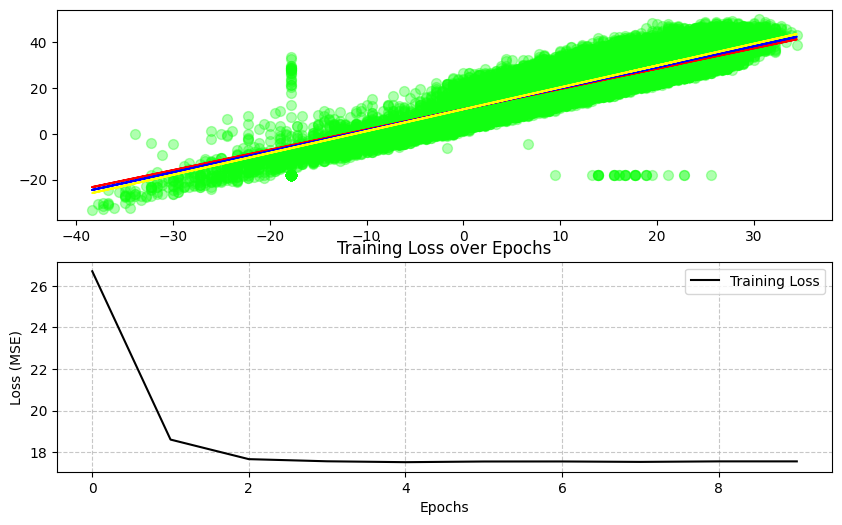

In [7]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2)
data_pt = fig.add_subplot(gs[0, :])
data_pt.scatter(X, y, color="#11ff1155", s=50)
pred_y = linear_unit.infer(X.tolist()).flatten()
data_pt.plot(X.tolist(), pred_y, label="Pred Func", color="red")
data_pt.plot(X.tolist(), sk_model.predict(X), label="LinearReg Func", color="blue")
data_pt.plot(
    X.tolist(), model_keras.predict(X), label="LinearReg Func", color="yellow"
)

loss_pt = fig.add_subplot(gs[1, :])
loss_pt.plot(linear_unit.epoch_loss_scores, label="Training Loss", color="black")
loss_pt.set_title("Training Loss over Epochs")
loss_pt.set_xlabel("Epochs")
loss_pt.set_ylabel("Loss (MSE)")
loss_pt.grid(True, linestyle="--", alpha=0.7)
loss_pt.legend()
plt.show()